In [2]:
import time
from functools import partial
from pathlib import Path
from zipfile import ZipFile

import dask.array as da
from dask.array.core import normalize_chunks
import numpy as np
from shapely.geometry import GeometryCollection, Point
from skimage.transform import AffineTransform

from fuse.fuse import fuse_func
from utils.download_sample import download_from_dropbox
from utils.metadata import extract_coordinates, normalize_coords_to_pixel
from utils.imutils import crop_black_border, load_image, transpose
from utils.shapely_and_napari_utils import get_transformed_array_corners, numpy_shape_to_shapely
from utils.chunks import get_chunk_coordinates, get_rect_from_chunk_boundary, find_chunk_tile_intersections

In [3]:
import pandas as pd
from tqdm.auto import tqdm
import re 
import os
from natsort import natsorted
import enum

# Loading own functions to sort files and extract metadata

In [39]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    PHASE = 4
    WEIGHTS = 50
    MASK_IRFP = 96
    MASK_RFP = 97
    MASK_GFP = 98
    MASK = 99
    
def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusLite filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSLITE_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<fov>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    pth, filename = os.path.split(filename)
    params = re.match(OCTOPUSLITE_FILEPATTERN, filename)

    metadata = {
        "filename": filename,
        "channel": Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "fov": params.group("fov"), 
        "plane": params.group("plane"), 
        "time": params.group("time"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return metadata

## Overview: creating a single, fused array from many image tiles that have associated affine transfomations.

This notebook demonstrates how dask's `map_blocks` can be leveraged to combine many images that have associated affine or perspective transforms into a single array. 

This is a scenario that is common when building image mosaics, e.g. a landscape panorama from multiple photos or a picture of part of a microscope slide combined from many individual microscope images.

For the sake of the notebook we assume that the spatial transformations that map the individual tiles into a common coordinate system are already known. Here, we don't discuss how to find these transforms, which could be done  through methods such as feature point matching and bundle adjustment or normalized cross corellation.

Instead, we focus on how dasks `map_blocks` can help with the process of fusing the individual tiles into a single array efficiently, especially for cases when the resulting output array is too large to fit in RAM.

To visualize the position of individual image tiles in this notebook we represent them as shapely objects.
This also facilitates finding image tiles intersecting chunks in a dask array, which we also represent as shapely objects.


# ~Download sample dataset~

# Attempting to tile a time-series

## Get a list of the input tile filenames

In [40]:
files = list(Path("/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/").glob("r03c03f*p01-ch1sk*fk*"))

In [41]:
len(files)

675

I.e. 75 timepoints x 9 FOVs

In [42]:
parse_filename(files[0])

{'filename': 'r03c03f07p01-ch1sk49fk1fl1.tiff',
 'channel': <Channels.GFP: 1>,
 'time': '49',
 'row': '03',
 'column': '03',
 'fov': '07',
 'plane': '01',
 'fk': '1',
 'fl': '1'}

In [43]:
files.sort(key=lambda f: int(parse_filename(f)["time"]))

In [44]:
for fn in files:
    print(fn)

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f03p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f09p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f02p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f07p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f06p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f08p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f04p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f05p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_liv

## Extract the required metadata and return it as a Dataframe

We obtain the pixel scale factor in micrometers per pixel as well as the stage position for each image tile in micrometers.

## Take the FOV and convert it to the XY position in a grid

In [82]:
coords = pd.DataFrame()
for fn in files:
    entry = pd.DataFrame([parse_filename(fn)])
    coords = pd.concat([coords, entry], ignore_index=True)


In [83]:
coords

,filename,channel,time,row,column,fov,plane,fk,fl
0,r03c03f03p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,03,01,1,1
1,r03c03f09p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,09,01,1,1
2,r03c03f02p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,02,01,1,1
3,r03c03f01p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,01,01,1,1
4,r03c03f07p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,07,01,1,1
...,...,...,...,...,...,...,...,...,...
670,r03c03f02p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,02,01,1,1
671,r03c03f01p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,01,01,1,1
672,r03c03f08p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,08,01,1,1
673,r03c03f03p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,03,01,1,1


#### Converting the fov to the XY coord in the grid

In [66]:
coords['X'], coords['Y'] = 0, 0

In [84]:
for i, row in coords.iterrows():
    n_rcs = int(np.sqrt(int(max(coords['fov']))))
    zero_index = int(row['fov']) - 1 
    rc = np.unravel_index(zero_index, [n_rcs,n_rcs], 'F')
    coords.at[i, 'X'] = rc[0]
    coords.at[i, 'Y'] = rc[1]

In [86]:
### lazy hack to register the row/col number as x/y location shifted by the amount of pixels in each image
coords['um/px'] = 1/2160

In [87]:
coords

,filename,channel,time,row,column,fov,plane,fk,fl,X,Y,um/px
0,r03c03f03p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,03,01,1,1,2.0,0.0,0.000463
1,r03c03f09p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,09,01,1,1,2.0,2.0,0.000463
2,r03c03f02p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,02,01,1,1,1.0,0.0,0.000463
3,r03c03f01p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,01,01,1,1,0.0,0.0,0.000463
4,r03c03f07p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,07,01,1,1,0.0,2.0,0.000463
...,...,...,...,...,...,...,...,...,...,...,...,...
670,r03c03f02p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,02,01,1,1,1.0,0.0,0.000463
671,r03c03f01p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,01,01,1,1,0.0,0.0,0.000463
672,r03c03f08p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,08,01,1,1,1.0,2.0,0.000463
673,r03c03f03p01-ch1sk75fk1fl1.tiff,Channels.GFP,75,03,03,03,01,1,1,2.0,0.0,0.000463


In the following, we work with pixel coordinates, therefore we convert the stage coordinates accordingly.

In [127]:
help(normalize_coords_to_pixel)

Help on function normalize_coords_to_pixel in module utils.metadata:

normalize_coords_to_pixel(coords: pandas.core.frame.DataFrame, xy_columns: Tuple[str, str] = ('X', 'Y'), scale_factor_column: str = 'um/px') -> pandas.core.frame.DataFrame
    Normalizes stage coordinates to pixels coordinates.



In [89]:
normalized_coords = normalize_coords_to_pixel(coords).to_numpy()
normalized_coords

array([[4320.,    0.],
       [4320., 4320.],
       [2160.,    0.],
       ...,
       [2160., 4320.],
       [4320.,    0.],
       [4320., 2160.]])

For this particular data set, we need to perform a few pre-processing steps on each image, such as cropping away a black border on one side of the image and transposing the image to account for the camera orientation relative to the stage. 
We configure a `_load_image` image function that performs these pre-processing steps for us:

In [95]:
input_transforms = None#[crop_black_border, ]#transpose]
_load_image = partial(load_image, transforms=input_transforms)

In the next step we load the first image to determine the shape of the image after the pre-processing steps. 
Here, we assume that all tiles have the same shape. (This is not strictly necessary). 

In [100]:
tile_shape=_load_image(str(files[0])).shape
tile_shape

(2160, 2160)

For each input tile, find out where its corners map after the transformation that puts it in a joint coordinate system.
Here, the transformation is a simple translation, but in general it could also be a more general affine transform (i.e. including rotations and scaling) or even a perspective transform (for photo mosaics). 

In [128]:
transforms

[array([[ 1.00e+00, -0.00e+00,  4.32e+03],
        [ 0.00e+00,  1.00e+00,  0.00e+00],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1.00e+00, -0.00e+00,  4.32e+03],
        [ 0.00e+00,  1.00e+00,  4.32e+03],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1.00e+00, -0.00e+00,  2.16e+03],
        [ 0.00e+00,  1.00e+00,  0.00e+00],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]]),
 array([[ 1.00e+00, -0.00e+00,  0.00e+00],
        [ 0.00e+00,  1.00e+00,  4.32e+03],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1.00e+00, -0.00e+00,  4.32e+03],
        [ 0.00e+00,  1.00e+00,  2.16e+03],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1.00e+00, -0.00e+00,  2.16e+03],
        [ 0.00e+00,  1.00e+00,  4.32e+03],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array([[ 1.00e+00, -0.00e+00,  0.00e+00],
        [ 0.00e+00,  1.00e+00,  2.16e+03],
        [ 0.00e+00,  0.00e+00,  1.00e+00]]),
 array

In [101]:
transforms = [AffineTransform(translation=stage_coord).params for stage_coord in normalized_coords]
tiles = [get_transformed_array_corners(tile_shape, transform) for transform in transforms]

Let's create shapely objects from the numpy arrays that hold the corner points.
If we also include the a shapely Point at (0,0) we can visualize where the tiles are with respect to the origin of the joint coordinate system. (As it may be hard to spot: look for the origin at he bottom left of the next cell's output).

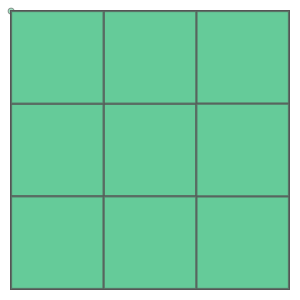

In [102]:
tiles_shapely = [numpy_shape_to_shapely(s) for s in tiles]
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shapely)))

## Determine required shape of the dask output array.

As we can see above, the image tiles are a fair way away from the origin. In the fused imgage, we don't want to include a lot of empty space.

We examine bounds of the stitched area to determine the size of the Zarr array we require.
We also find a translation that shifts the top-left corner of all tiles to (0,0) and update the initial transforms by chaining them with this translation.

In [103]:
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
stitched_shape

(6480, 6480)

In [104]:
shift_to_origin = AffineTransform(translation=-all_min)
shift_to_origin.params

array([[ 1., -0., -0.],
       [ 0.,  1., -0.],
       [ 0.,  0.,  1.]])

In [106]:
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [get_transformed_array_corners(tile_shape, t) for t in transforms_with_shift]

We visualize the tile boundaries after the additional translation to verify that the corner of the mosaic is now at the origin.

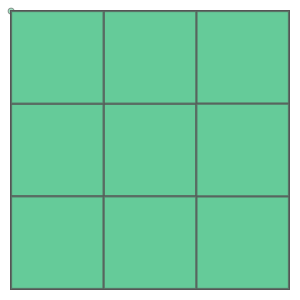

In [107]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shifted_shapely)))

## Create a dask array for the fused image

We need to decide on a suitable chunk size. Later, each chunk will be processed separately and possibly in parallel using `map_blocks`. Choosing a chunk size is a trade-off between memory and performance. 
If we choose the chunk size too large, the memory requirements for each chunk increase. 
If we choose the chunk size too small, the situation where a tile intersects multiple chunks will occur more often. This potentially leads to multiple disk access for the same tile.

Other considerations for the chunk size is the chunking that is needed in the output file (we use a zarr array), e.g. for a viewer such as napari.

On my machine I empirically found (4096, 4096)  a good trade-off, but you can experiment with other chunk sizes.

In [108]:
chunk_size = (2160,2160)

In [109]:
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
chunks

((2160, 2160, 2160), (2160, 2160, 2160))

We just convince ourselves that all the chunks taken together have the same size as `stitched_shape`:

In [110]:
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)
computed_shape, stitched_shape

(array([6480, 6480]), (6480, 6480))

Compute tuples of coorindates with which we can slice the destination array to get a single chunk:

In [111]:
chunk_boundaries = list(get_chunk_coordinates(stitched_shape, chunk_size))
chunk_boundaries

[((0, 2160), (0, 2160)),
 ((0, 2160), (2160, 4320)),
 ((0, 2160), (4320, 6480)),
 ((2160, 4320), (0, 2160)),
 ((2160, 4320), (2160, 4320)),
 ((2160, 4320), (4320, 6480)),
 ((4320, 6480), (0, 2160)),
 ((4320, 6480), (2160, 4320)),
 ((4320, 6480), (4320, 6480))]

We also create shapely objects of the chunks so we can visualize them in the notebook and to make it easier to determine which tiles intersect a given chunk and therefore need to be processed in that block.

In [112]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

Now we can visualize both the chunks and the tiles to see the overlaps:

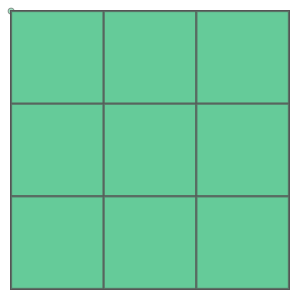

In [113]:
GeometryCollection([origin, 
                    GeometryCollection(tiles_shifted_shapely), 
                    GeometryCollection(chunks_shapely),])

In [114]:
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely, 
                                                 files, 
                                                 transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}

/tmp/ipykernel_271263/2267014653.py:4: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}


In [115]:
for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}

/tmp/ipykernel_271263/1780256429.py:2: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}


Next, we create a data structure that holds alls the information regarding the tiles that are needed to perform the fusion of arrays ins a given chunk.

We choose a dictionary that is indexed by the top-left coordinate tuple of each chunk.

In [116]:
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
chunk_tiles

{(0,
  0): [(PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk17fk1fl1.tiff'),
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk53fk1fl1.tiff'),
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk49fk1fl1.tiff'),
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk63fk1fl1.tiff'),
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f01p01-ch1sk35fk1fl1.tiff'),
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1

We inspect one of these dict entries to see that it contains a list of tuples with information about each intersecting tile: file path and affine transformation matrix for that particular tile.

In [117]:
chunk_tiles[(2160,2160)]

[(PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f02p01-ch1sk71fk1fl1.tiff'),
  array([[1.00e+00, 0.00e+00, 2.16e+03],
         [0.00e+00, 1.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 1.00e+00]])),
 (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f02p01-ch1sk13fk1fl1.tiff'),
  array([[1.00e+00, 0.00e+00, 2.16e+03],
         [0.00e+00, 1.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 1.00e+00]])),
 (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f02p01-ch1sk1fk1fl1.tiff'),
  array([[1.00e+00, 0.00e+00, 2.16e+03],
         [0.00e+00, 1.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 1.00e+00]])),
 (PosixPath('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c03f02p01-ch1sk49fk1fl1.tiff'),
  array([[1.00e+00, 0.00e+00, 2.16e+03],
         [0.00e+00, 1.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 1.00e+00]])

At this stage, we can use `map_blocks` to calculate the fused image chunk by chunk.
To do so, we pass a function `_fuse_func` to `map_blocks` that will get called for each chunk.

You may want to closely inspect `fuse_func` that we imported in `fuse.py`. It takes 
care of loading all the tiles for the particular chunk it is processing and applying 
the respective affine transforms. It also applies an additional translation to the individual affine
transforms, to account for the fact that the coordinates in the chunk are relative to the chunks location
in the target array.

By processing each chunk individually, only the source tiles overlapping that particular chunk will have to be loaded into memory. Thus we can generate a large fused array even on a machine with limited RAM. This is an example of using dask for ["out-of-core"](https://en.wikipedia.org/wiki/External_memory_algorithm) processing.

Using `partial` function evaluation we set some of the arguments of `fuse_func`, for example the image file loader. It is this partially evaluated function we pass to `map_blocks`.

In [118]:
_fuse_func=partial(fuse_func, 
                   imload_fn=_load_image,
                   dtype=np.uint16)


target_array = da.map_blocks(func=_fuse_func,
                             chunks=chunks, 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint16)

In [119]:
target_array

dask.array<fuse_func, shape=(6480, 6480), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

Up to this point, the computation that maps the tiles into the destination array hasn't been computed.
We can trigger the computation by writing the array into a `zarr` file on disk.

In [ ]:
target_array.to_zarr("fused.zarr", overwrite=True)

The command above writes a simple chunked zarr array. For large mosaics it may be useful to write a multi-resolution image pyramid, e.g. using this https://github.com/aeisenbarth/ngff-writer package to write the dask array to a multi-resolution `.ome.zarr` (an emerging NGFF file format).


If you want to look at at the zarr array, you can use napari which supports loading zarr files:

In [121]:
import napari
from napari.utils import nbscreenshot

In [122]:
v = napari.Viewer()
v.add_image(da.from_zarr("fused.zarr"), name="Fused")

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Fused' at 0x7f41745169a0>

In [126]:
da.from_zarr("fused.zarr")

dask.array<from-zarr, shape=(6480, 6480), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [ ]:
nbscreenshot(v)

# Running a shortened version of all the above for each time frame

In [152]:
for t in tqdm(range(1,76)):
    files = list(Path("/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/").glob(f"r03c03f*p01-ch1sk{t}fk*"))
    files.sort(key=lambda f: int(parse_filename(f)["time"]))
    coords = pd.DataFrame()
    for fn in files:
        entry = pd.DataFrame([parse_filename(fn)])
        coords = pd.concat([coords, entry], ignore_index=True)
    for i, row in coords.iterrows():
        n_rcs = int(np.sqrt(int(max(coords['fov']))))
        zero_index = int(row['fov']) - 1 
        rc = np.unravel_index(zero_index, [n_rcs,n_rcs], 'F')
        coords.at[i, 'Y'] = rc[0]
        coords.at[i, 'X'] = rc[1]
    ### lazy hack to register the row/col number as x/y location shifted by the amount of pixels in each image
    coords['um/px'] = 1/2160
    normalized_coords = normalize_coords_to_pixel(coords).to_numpy()
    input_transforms = None#[crop_black_border, ]#transpose]
    _load_image = partial(load_image, transforms=input_transforms)
    tile_shape=_load_image(str(files[0])).shape
    transforms = [AffineTransform(translation=stage_coord).params for stage_coord in normalized_coords]
    tiles = [get_transformed_array_corners(tile_shape, transform) for transform in transforms]
    tiles_shapely = [numpy_shape_to_shapely(s) for s in tiles]
    origin = Point(0,0)
    all_bboxes = np.vstack(tiles)
    all_min = all_bboxes.min(axis=0)
    all_max = all_bboxes.max(axis=0)
    stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
    shift_to_origin = AffineTransform(translation=-all_min)
    transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
    shifted_tiles = [get_transformed_array_corners(tile_shape, t) for t in transforms_with_shift]
    tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
    origin = Point(0,0)
    chunk_size = (2160,2160)
    chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
    computed_shape = np.array(list(map(sum, chunks)))
    assert np.all(np.array(stitched_shape) == computed_shape)
    chunk_boundaries = list(get_chunk_coordinates(stitched_shape, chunk_size))
    chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
    chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
    for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely, 
                                                     files, 
                                                     transforms_with_shift):
        tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}
    for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
        chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
    chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
    _fuse_func=partial(fuse_func, 
                       imload_fn=_load_image,
                       dtype=np.uint16)


    target_array = da.map_blocks(func=_fuse_func,
                                 chunks=chunks, 
                                 input_tile_info=chunk_tiles,
                                 dtype=np.uint16)
    target_array.to_zarr(f"time_array/t{t}_fused.zarr", overwrite=True)


  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_271263/1637832969.py:43: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}
/tmp/ipykernel_271263/1637832969.py:45: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}


Processing chunk at (0, 0)Processing chunk at (0, 2160)

Processing chunk at (0, 4320)
Processing chunk at (2160, 0)
Processing chunk at (2160, 2160)
Processing chunk at (2160, 4320)Processing chunk at (4320, 0)

Processing chunk at (4320, 2160)
Processing chunk at (4320, 4320)


In [154]:
for i, row in coords.iterrows():
    if row['FOV'] == '04';
        coords.at[i, 'Y'] = 2.0
        coords.at[i, 'X'] = 1.0
    elif row['FOV'] == '06';
        coords.at[i, 'Y'] = 1.0
        coords.at[i, 'X'] = 2.0
    else:
        n_rcs = int(np.sqrt(int(max(coords['fov']))))
        zero_index = int(row['fov']) - 1 
        rc = np.unravel_index(zero_index, [n_rcs,n_rcs], 'F')
        coords.at[i, 'Y'] = rc[0]
        coords.at[i, 'X'] = rc[1]


In [155]:
coords

,filename,channel,time,row,column,fov,plane,fk,fl,Y,X,um/px
0,r03c03f03p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,03,01,1,1,2.0,0.0,0.000463
1,r03c03f09p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,09,01,1,1,2.0,2.0,0.000463
2,r03c03f02p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,02,01,1,1,1.0,0.0,0.000463
3,r03c03f01p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,01,01,1,1,0.0,0.0,0.000463
4,r03c03f07p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,07,01,1,1,0.0,2.0,0.000463
5,r03c03f06p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,06,01,1,1,2.0,1.0,0.000463
6,r03c03f08p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,08,01,1,1,1.0,2.0,0.000463
7,r03c03f04p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,04,01,1,1,0.0,1.0,0.000463
8,r03c03f05p01-ch1sk1fk1fl1.tiff,Channels.GFP,1,03,03,05,01,1,1,1.0,1.0,0.000463


In [144]:
from skimage.io import imshow, imread

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


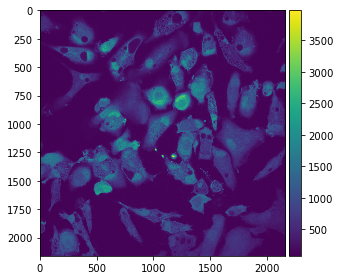

In [145]:
imshow(imread(files[0]))

In [146]:
imread(files[0])

array([[125, 126, 116, ..., 106, 101, 109],
       [127, 127, 116, ..., 100, 100, 105],
       [136, 132, 124, ...,  99, 104, 105],
       ...,
       [151, 137, 135, ..., 107, 103, 103],
       [146, 152, 161, ..., 110, 109, 101],
       [156, 168, 160, ..., 105, 106, 103]], dtype=uint16)

The command above writes a simple chunked zarr array. For large mosaics it may be useful to write a multi-resolution image pyramid, e.g. using this https://github.com/aeisenbarth/ngff-writer package to write the dask array to a multi-resolution `.ome.zarr` (an emerging NGFF file format).


If you want to look at at the zarr array, you can use napari which supports loading zarr files:

In [121]:
import napari
from napari.utils import nbscreenshot

In [147]:
v = napari.Viewer()
v.add_image(da.from_zarr("fused.zarr"), name="Fused")

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Fused' at 0x7f414042a8e0>